In [1]:
from csromer.simulation import FaradayThinSource,FaradayThickSource
from csromer.reconstruction import Parameter
import numpy as np
from IPython.display import clear_output
from csromer.io import Reader, Writer
from csromer.base import Dataset
from csromer.transformers import DFT1D, NUFFT1D
import matplotlib.pyplot as plt
from csromer.objectivefunction import OFunction
from csromer.utils import real_to_complex, complex_to_real
from csromer.objectivefunction import TSV, TV, L1, Chi2
from csromer.dictionaries import UndecimatedWavelet, DiscreteWavelet
from csromer.optimization import FISTA, ADMM, SDMM, GradientBasedMethod
from csromer.utils import Gaussian
from csromer.transformers import Gridding
from scipy.constants import c
from pynufft import NUFFT
from scipy import signal as sci_signal
import itertools
import copy
from scipy.stats import median_abs_deviation
from scipy import stats

In [2]:
def chi2_calc(residuals):
    if residuals.dtype == np.complex64 or residuals.dtype == np.complex128:
        data = (residuals.real * residuals.real) + (residuals.imag * residuals.imag)
    else:
        data = residuals**2
    return np.sum(data)

In [3]:
def aicbic(residuals_coeffs, x_coeffs):
    rss = chi2_calc(residuals)
    if x.dtype == np.complex64 or x.dtype == np.complex128:
        df = np.count_nonzero(x.real) + np.count_nonzero(x.imag)
    else:     
        df = np.count_nonzero(x)
    l = len(residuals)
    return l*np.log(rss/l) + 2*df, l*np.log(rss/l) + df*np.log(l)

In [4]:
def aicbic(residuals, x):
    rss = chi2_calc(residuals)
    if x.dtype == np.complex64 or x.dtype == np.complex128:
        df = np.count_nonzero(x.real) + np.count_nonzero(x.imag)
        lcoeffs = 2*len(x)
    else:     
        df = np.count_nonzero(x)
        lcoeffs = len(x)
    l = len(residuals)
    print("len(coeffs):", lcoeffs)
    print("l:", l)
    print("df:", df)
    print("rss:",rss)
    print("rss/l", rss/l)
    print("log(rss/l)", np.log(rss/l))
    print("log(l)", np.log(l))
    return l*np.log(rss/l) + 2*df, l*np.log(rss/l) + df*np.log(l)

In [5]:
np.random.seed(666)

In [6]:
# JVLA 1.008e9 2.031e9 1000
nu = np.linspace(start=1.008e9, stop=2.031e9, num=1000)

In [7]:
peak_thinsource = 0.0035
peak_thicksource = 0.0035

In [8]:
thinsource = FaradayThinSource(nu=nu, s_nu=peak_thinsource, phi_gal=-200, spectral_idx=1.0)

In [9]:
#140 JVLA
# 95 MeerKAT
thicksource = FaradayThickSource(nu=nu, s_nu=peak_thicksource, phi_fg=140, phi_center=200, spectral_idx=0.0)

In [10]:
thinsource.simulate()
thicksource.simulate()

In [11]:
simsource = thinsource

In [12]:
original_source = copy.deepcopy(simsource)

In [13]:
simsource.remove_channels(0.3)

In [14]:
peak_thinsource

0.0035

In [15]:
applied_noise = 0.1*peak_thinsource

In [16]:
applied_noise * 1000.0

0.35000000000000003

In [17]:
#simsource.data = np.random.normal(loc=0.0, scale=applied_noise, size=simsource.m) + 1j * np.random.normal(loc=0.0, scale=applied_noise, size=simsource.m) 

In [18]:
simsource.apply_noise(applied_noise, np.random.RandomState(666))

In [19]:
simsource.theo_noise

1.3228756555322953e-05

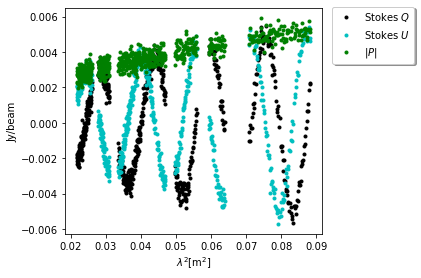

In [20]:
plt.plot(simsource.lambda2, simsource.data.real, 'k.', label=r"Stokes $Q$")
plt.plot(simsource.lambda2, simsource.data.imag, 'c.', label=r"Stokes $U$")
plt.plot(simsource.lambda2, np.abs(simsource.data), 'g.', label=r"$|P|$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
plt.legend(loc=(1.04, 0.755), fancybox=True, shadow=True)
plt.tight_layout()
#plt.ylim([-0.01,0.01])
#plt.savefig("pol_sim1.png", dpi=100)

In [21]:
sigma_qu = 0.5 * (np.std(simsource.data.real) + np.std(simsource.data.imag))
sigma_qu * 1000.0

2.6320884668235367

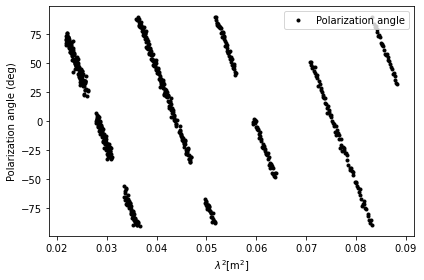

In [22]:
import astropy.units as u
plt.plot(simsource.lambda2, simsource.calculate_polangle('data').to(u.deg), 'k.', label=r"Polarization angle")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Polarization angle (deg)')
plt.legend(loc='upper right')
plt.tight_layout()

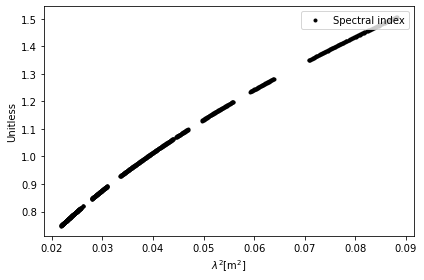

In [23]:
plt.plot(simsource.lambda2, simsource.s, 'k.', label=r"Spectral index")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Unitless')
plt.legend(loc='upper right')
plt.tight_layout()

In [24]:
dataset = simsource

In [25]:
parameter = Parameter()
original_parameter = Parameter()

In [26]:
original_parameter.calculate_cellsize(dataset=original_source, oversampling=8)

FWHM of the main peak of the RMTF: 51.962 rad/m^2
Maximum recovered width structure: 144.188 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 25954.896


In [27]:
parameter.calculate_cellsize(dataset=dataset, oversampling=8)

FWHM of the main peak of the RMTF: 52.102 rad/m^2
Maximum recovered width structure: 144.188 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 18209.648


In [28]:
nufft = NUFFT1D(dataset=dataset, parameter=parameter, solve=True)

In [29]:
dft = DFT1D(dataset=dataset, parameter=parameter)
dft_original = DFT1D(dataset=original_source, parameter=original_parameter)

In [30]:
F_dirty = dft.backward(dataset.data)
F_dirty_original = dft_original.backward(original_source.data)

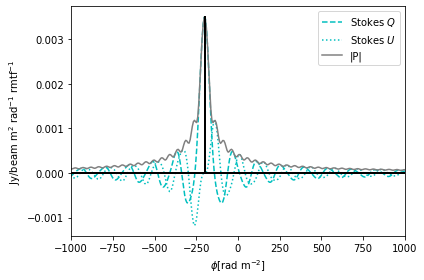

In [31]:
plt.plot(original_parameter.phi, F_dirty_original.real, 'c--', label=r"Stokes $Q$")
plt.plot(original_parameter.phi, F_dirty_original.imag, 'c:', label=r"Stokes $U$")
plt.plot(original_parameter.phi, np.abs(F_dirty_original), '-', c='grey', label=r"|P|")
plt.plot([-200.,-200.],[0.,0.0035],ls='-',lw=2.,c='black')
plt.plot(original_parameter.phi,np.zeros(len(original_parameter.phi)),ls='-',lw=2.,c='black')
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000,1000])
plt.tight_layout()
#plt.savefig("fds_sim1.png", dpi=100)

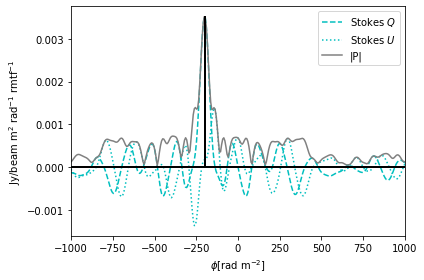

In [32]:
plt.plot(parameter.phi, F_dirty.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_dirty.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_dirty), '-', c='grey', label=r"|P|")
plt.plot([-200.,-200.],[0.,0.0035],ls='-',lw=2.,c='black')
plt.plot(parameter.phi,np.zeros(len(parameter.phi)),ls='-',lw=2.,c='black')
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000,1000])
plt.tight_layout()
#plt.savefig("fds_sim1.png", dpi=100)

In [33]:
idx_noise = np.where(np.abs(parameter.phi)>0.8*parameter.max_faraday_depth)
noise_F = 0.5*(median_abs_deviation(F_dirty[idx_noise].real, scale="normal") + median_abs_deviation(F_dirty[idx_noise].imag, scale="normal"))
noise_F*1000.0

0.03221460984109576

In [34]:
noise_from_w = 1.0/np.sqrt(np.sum(dataset.w))
noise_from_w * 1000.0

0.013228756555322952

In [35]:
F_back = dft.backward(dataset.data)

(-1000.0, 1000.0)

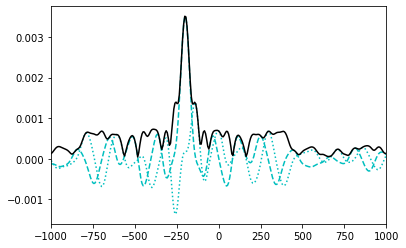

In [36]:
plt.plot(parameter.phi, F_back.real, 'c--', label=r"Real part")
plt.plot(parameter.phi, F_back.imag, 'c:', label=r"Imaginary part")
plt.plot(parameter.phi, np.abs(F_back), 'k-', label=r"Amplitude")
plt.xlim([-1000,1000])

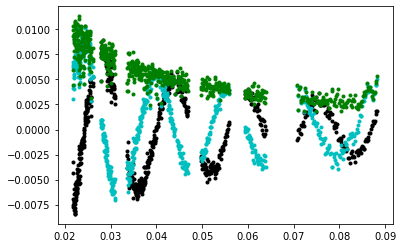

In [37]:
P_back = nufft.forward_normalized(F_back)
plt.plot(dataset.lambda2, P_back.real, 'k.', label=r"Stokes $Q$")
plt.plot(dataset.lambda2, P_back.imag, 'c.', label=r"Stokes $U$")
plt.plot(dataset.lambda2, np.abs(P_back), 'g.', label=r"$|P|$")

In [38]:
wav = None
#wav = DiscreteWavelet(wavelet_name="db3", mode="periodization", append_signal=True)
#wav = UndecimatedWavelet(wavelet_name="coif2", append_signal=False)

In [39]:
parameter.data = F_dirty
parameter.complex_data_to_real()
if wav is not None:
    wav.calculate_max_level(parameter.data)
    parameter.data = wav.decompose(parameter.data)
    plt.plot(parameter.data*1000.0)
    coeff_noise = median_abs_deviation(parameter.data[-1000:-1]) / 0.6745
    print(coeff_noise * 1000.0)

In [40]:
len(parameter.data)

11136

In [41]:
lambda_l1 = np.sqrt(dataset.m + 2*np.sqrt(dataset.m)) * dataset.theo_noise
#lambda_l1 = np.sqrt(dataset.m) * noise_F
#print(lambda_l1)
#lambda_l1 /= 2
#lambda_l1=0.5
lambda_tsv = 0.0
chi2 = Chi2(dft_obj=nufft, wavelet=wav)
l1 = L1(reg=lambda_l1)
tsv = TSV(reg=lambda_tsv)
# F_func = [chi2(P, dft, W), L1(lambda_l1)]
F_func = [chi2, l1]
f_func = [chi2]
g_func = [l1]

F_obj = OFunction(F_func)
f_obj = OFunction(f_func)
g_obj = OFunction(g_func)

In [42]:
lambda_l1

0.00036298778159702023

In [43]:
dataset.theo_noise

1.3228756555322953e-05

In [44]:
lambda_l1 / (dataset.theo_noise)

27.439297116021244

In [45]:
opt = FISTA(guess_param=parameter, F_obj=F_obj, fx=chi2, gx=g_obj, noise=dataset.theo_noise, verbose=True)
#opt = FISTA(i_guess=F_real, F_obj=F_obj, fx=chi2, gx=g_obj, maxiter=1000, noise=1e-5, verbose=True)
obj, X = opt.run()
print(obj)

Iterations set to 27
Iteration:  0  objective function value: 11626.28976
Iteration:  10  objective function value: 2515.70501
Iteration:  20  objective function value: 1239.78047
777.0392684576912


In [46]:
if wav is not None:
    plt.plot(X.data)

In [47]:
if wav is not None:
    X.data = wav.reconstruct(X.data)
X.real_data_to_complex()

(-1000.0, 1000.0)

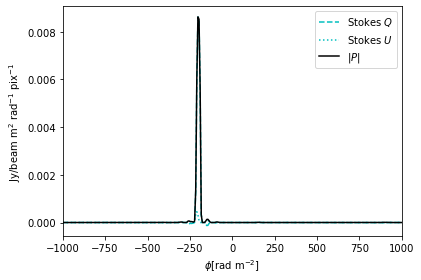

In [48]:
plt.plot(parameter.phi, X.data.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, X.data.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(X.data), 'k-', label=r"$|P|$")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ pix$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlim([-1000,1000])

In [49]:
model_data_2 = nufft.forward_normalized(X.data)

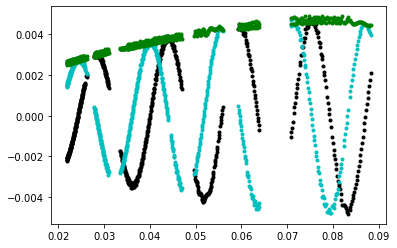

In [50]:
plt.plot(dataset.lambda2, dataset.model_data.real, 'k.', label=r"Stokes $Q$")
plt.plot(dataset.lambda2, dataset.model_data.imag, 'c.', label=r"Stokes $U$")
plt.plot(dataset.lambda2, np.abs(dataset.model_data), 'g.', label=r"$|P|$")

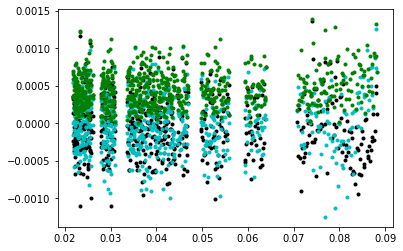

In [51]:
plt.plot(dataset.lambda2, dataset.residual.real, 'k.', label=r"Stokes $Q$")
plt.plot(dataset.lambda2, dataset.residual.imag, 'c.', label=r"Stokes $U$")
plt.plot(dataset.lambda2, np.abs(dataset.residual), 'g.', label=r"$|P|$")

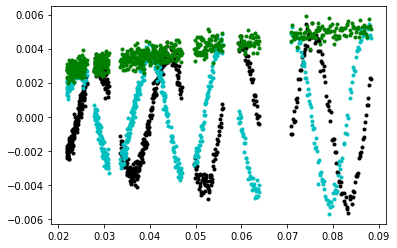

In [52]:
plt.plot(dataset.lambda2, dataset.data.real, 'k.', label=r"Stokes $Q$")
plt.plot(dataset.lambda2, dataset.data.imag, 'c.', label=r"Stokes $U$")
plt.plot(dataset.lambda2, np.abs(dataset.data), 'g.', label=r"$|P|$")

In [53]:
sigma_res = 0.5*(np.std(dataset.residual.real) + np.std(dataset.residual.imag)) 

In [54]:
sigma_res * 1000.0

0.3685335022204771

In [55]:
F_residual = dft.backward(dataset.residual)

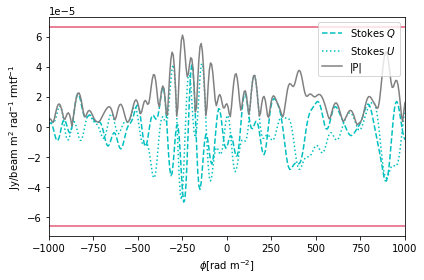

In [56]:
plt.plot(parameter.phi, F_residual.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_residual.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_residual), '-', c='grey', label=r"|P|")
#plt.plot([-200.,-200.],[0.,0.0035],ls='-',lw=2.,c='black')
#plt.plot(parameter.phi,np.zeros(len(parameter.phi)),ls='-',lw=2.,c='black')
plt.axhline (y = 5*dataset.theo_noise, color = 'crimson', alpha=0.7)
plt.axhline (y = -5*dataset.theo_noise, color = 'crimson', alpha=0.7)
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000,1000])
plt.tight_layout()
#plt.savefig("fds_sim1.png", dpi=100)

In [57]:
rms_residual = 0.5*(np.std(F_residual.real) + np.std(F_residual.imag))
rms_residual*1000.0

0.013921257050242275

In [58]:
dataset.theo_noise * 1000.0

0.013228756555322952

In [59]:
noise_F*1000.0

0.03221460984109576

In [60]:
applied_noise * 1000.0

0.35000000000000003

In [61]:
sigma_qu*1000.0

2.6320884668235367

In [62]:
model_2 = dft.backward(dataset.model_data)

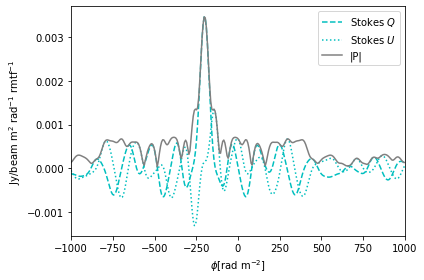

In [63]:
plt.plot(parameter.phi, model_2.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, model_2.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(model_2), '-', c='grey', label=r"|P|")
#plt.plot([-200.,-200.],[0.,0.0035],ls='-',lw=2.,c='black')
#plt.plot(parameter.phi,np.zeros(len(parameter.phi)),ls='-',lw=2.,c='black')
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000,1000])
plt.tight_layout()
#plt.savefig("fds_sim1.png", dpi=100)

In [64]:
residual_faraday = F_dirty - model_2

In [65]:
conv_model = X.convolve() + F_residual

In [66]:
SMALL_SIZE = 17
MEDIUM_SIZE = 18
BIGGER_SIZE = 19

plt.rcParams.update({
                "font.family": "serif",
                "text.usetex": True,
                "pgf.rcfonts": False,
                "pgf.texsystem": 'pdflatex',  # default is xetex
            })

plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize

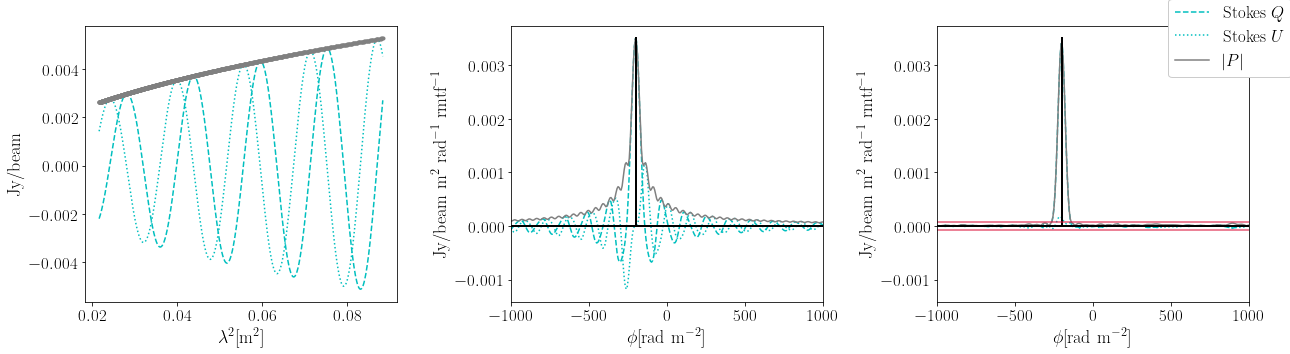

In [67]:
fig = plt.figure(figsize =(18,5))
#fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(original_source.lambda2, original_source.data.real, 'c--', label=r"Stokes $Q$")
ax1.plot(original_source.lambda2, original_source.data.imag, 'c:', label=r"Stokes $U$")
ax1.plot(original_source.lambda2, np.abs(original_source.data), '.', color="grey", label=r"$|P|$")
ax1.set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax1.set_ylabel(r'Jy/beam')


ax2 = fig.add_subplot(1, 3, 2)
ax2.plot(original_parameter.phi, F_dirty_original.real, 'c--', label=r"Stokes $Q$")
ax2.plot(original_parameter.phi, F_dirty_original.imag, 'c:', label=r"Stokes $U$")
ax2.plot(original_parameter.phi, np.abs(F_dirty_original), '-', c='grey', label=r"|P|")
ax2.plot([-200.,-200.],[0.,0.0035],ls='-',lw=2.,c='black')
#ax2.plot([130.,130.],[0.,0.0035],ls='-',lw=2.,c='black')
#ax2.plot([270.,270.],[0.,0.0035],ls='-',lw=2.,c='black')
#ax2.plot([130.,270.],[0.0035,0.0035],ls='-',lw=2.,c='black')
ax2.plot(original_parameter.phi,np.zeros(len(original_parameter.phi)),ls='-',lw=2.,c='black')
#ax2.axhline (y = 5*original_source.theo_noise*1000.0, color = 'crimson', alpha=0.7)
#ax2.axhline (y = -5*original_source.theo_noise*1000.0, color = 'crimson', alpha=0.7)
ax2.set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax2.set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax2.set_xlim([-1000,1000])

ax3 = fig.add_subplot(1, 3, 3, sharex = ax2, sharey = ax2)
ax3.plot(parameter.phi, conv_model.real, 'c--', label=r"Stokes $Q$")
ax3.plot(parameter.phi, conv_model.imag, 'c:', label=r"Stokes $U$")
ax3.plot(parameter.phi, np.abs(conv_model), '-', c='grey', label=r"$|P|$")
ax3.plot([-200.,-200.],[0.,0.0035],ls='-',lw=2.,c='black')
#ax3.plot([130.,130.],[0.,0.0035],ls='-',lw=2.,c='black')
#ax3.plot([270.,270.],[0.,0.0035],ls='-',lw=2.,c='black')
#ax3.plot([130.,270.],[0.0035,0.0035],ls='-',lw=2.,c='black')
ax3.plot(parameter.phi,np.zeros(len(parameter.phi)),ls='-',lw=2.,c='black')
#ax3.set_xlim([-1000,1000])
ax3.axhline(y = 5*dataset.theo_noise, color = 'crimson', alpha=0.7)
ax3.axhline(y = -5*dataset.theo_noise, color = 'crimson', alpha=0.7)
ax3.set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax3.set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')

handles, labels = ax3.get_legend_handles_labels()
legend = fig.legend(handles, labels, loc="upper right", borderaxespad=0)
legend.get_frame().set_alpha(1.0)
fig.tight_layout()
#fig.savefig("thinthick.pdf", dpi=500)

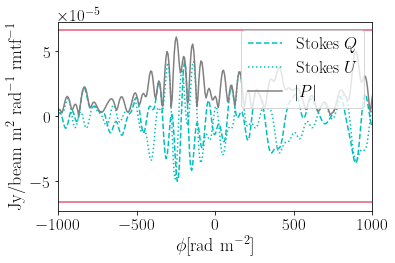

In [68]:
plt.plot(parameter.phi, residual_faraday.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, residual_faraday.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(residual_faraday), '-', c='grey', label=r"$|P|$")
#plt.plot([-200.,-200.],[0.,0.0035],ls='-',lw=2.,c='black')
#plt.plot(parameter.phi,np.zeros(len(parameter.phi)),ls='-',lw=2.,c='black')
plt.axhline (y = 5*dataset.theo_noise, color = 'crimson', alpha=0.7)
plt.axhline (y = -5*dataset.theo_noise, color = 'crimson', alpha=0.7)
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000,1000])
plt.tight_layout()
#plt.savefig("fds_sim1.png", dpi=100)

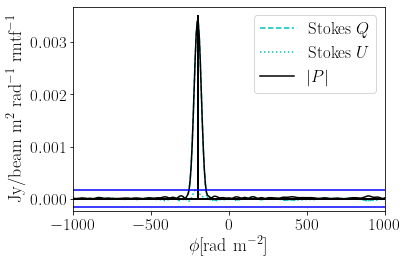

In [69]:
plt.plot(parameter.phi, conv_model.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, conv_model.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(conv_model), 'k-', label=r"$|P|$")
plt.plot([-200.,-200.],[0.,0.0035],ls='-',lw=2.,c='black')
plt.plot(parameter.phi,np.zeros(len(parameter.phi)),ls='-',lw=2.,c='black')
plt.xlim([-1000,1000])
plt.axhline (y = 5*noise_F, color = 'b')
plt.axhline (y = -5*noise_F, color = 'b')
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig("restored.png", dpi=100)

In [70]:
np.nanmax(np.abs(conv_model))

0.0034017978642821604

In [71]:
P = np.sqrt(np.max(np.abs(conv_model))**2 - (2.3*rms_residual**2))

In [72]:
parameter.rmtf_fwhm/(2*P/rms_residual)

0.10661116563682757

In [73]:
residual_1d = np.concatenate([residual_faraday.real, residual_faraday.imag])
#residual_1d = np.concatenate([dataset.residual.real, dataset.residual.imag])
stat,p = stats.jarque_bera(residual_1d)

In [74]:
print("stat={0:.3f}, p={1:.3f}".format(stat, p))

stat=0.247, p=0.884


In [75]:
p

0.8838905909632484

In [76]:
if p > 0.05:
    print("Probably Gaussian")
else:
    print("Probably not Gaussian")

Probably Gaussian
